In [23]:
import zipfile

zip_file_path = 'Assignment2_BikeHorses.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    extract_path = 'DATASET'
    zip_ref.extractall(extract_path)


In [30]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#---------------------------------------------------------------------------------------<Reading Dataset>-----||
def load_images(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(os.path.basename(folder_path))

    return images, labels

bikes_folder = 'DATASET/Assignment2_BikeHorses/Bikes'
horses_folder = 'DATASET/Assignment2_BikeHorses/Horses'

bike_images, bike_labels = load_images(bikes_folder)
horse_images, horse_labels = load_images(horses_folder)
num_bike_images = len(bike_images)
num_horse_images = len(horse_images)
print("Number of Bike Images:", num_bike_images)
print("Number of Horse Images:", num_horse_images)

bike_labels.extend(horse_labels) #MergeLabels

all_labels = []
all_labels.append(bike_labels)

#----------------------------------------------------------------------------------------------<Features>-----||
sift = cv2.SIFT_create() #SIFT
bike_descriptors = []
horse_descriptors = []
all_descriptors = []

for img in bike_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    bike_descriptors.extend(descriptors)

for img in horse_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    horse_descriptors.extend(descriptors)

all_descriptors.extend(bike_descriptors)
all_descriptors.extend(horse_descriptors)

# Kmeans
all_descriptors = np.array(all_descriptors)
num_clusters = 100
kmeans = KMeans(num_clusters)
kmeans.fit(all_descriptors)

# Histogram representation
histograms = []
for img in bike_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)

    labels = kmeans.predict(descriptors) # Assigning each descriptor to a cluster
    histogram, _ = np.histogram(labels, bins=range(num_clusters+1)) # Histogram based on the cluster labels and assigning bins
    histograms.append(histogram)

for img in horse_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)

    labels = kmeans.predict(descriptors) # Assigning each descriptor to a cluster
    histogram, _ = np.histogram(labels, bins=range(num_clusters+1)) # Histogram based on the cluster labels and assigning bins
    histograms.append(histogram)

#----------------------------------------------------------------------------------------<Classification>-----||
features = np.array(histograms)
labels = np.array([0] * num_bike_images + [1] * num_horse_images) # Assiging 0 for bikes, 1 for horses

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42) #Split datasets
classifier = SVC() # SVM - Support vector Classification
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) #Accuray Score

#--------------------------------------------------------------------------------------<Saving model pkl>-----||
import pickle # Saving the model
with open('svm_classifier.pkl', 'wb') as file:
    pickle.dump(classifier,file)

Number of Bike Images: 80
Number of Horse Images: 99


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.8611111111111112


In [33]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
LR_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", LR_accuracy)  # Accuracy Score

Accuracy: 0.9722222222222222


In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
KNN_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", KNN_accuracy)  # Accuracy Score

Accuracy: 0.8611111111111112


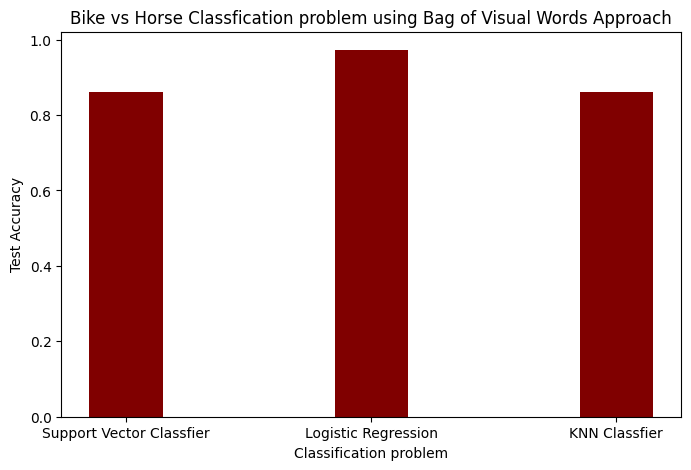

In [36]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'Support Vector Classfier':accuracy, 'Logistic Regression':LR_accuracy, 'KNN Classfier':KNN_accuracy}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', width = 0.3)

plt.xlabel("Classification problem")
plt.ylabel("Test Accuracy")
plt.title("Bike vs Horse Classfication problem using Bag of Visual Words Approach")
plt.show()

In [ ]:
import cv2
import os
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def load_images(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
    return images

#--------------------------------------------------------------------------------------------<Load model>-----||
with open('svm_classifier.pkl', 'rb') as file: # Load the classifier from the file
    loaded_classifier = pickle.load(file)

    Test_folder = 'Test'
    Test_images = load_images(Test_folder)
    predictions = []

#-----------------------------------------------------------------------------<SIFT, K-means, Classifier>-----||
    for img_path, new_img in zip(sorted(os.listdir(Test_folder)), Test_images):
        gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
        _, descriptors = sift.detectAndCompute(gray, None) #SIFT

        new_image_descriptors = np.array(descriptors)
        new_image_labels = kmeans.predict(new_image_descriptors) #Kmeans
        new_image_histogram, _ = np.histogram(new_image_labels, bins=range(num_clusters + 1)) #Histogram
        new_image_feature = np.array([new_image_histogram])

        prediction = loaded_classifier.predict(new_image_feature) #Classify
        predictions.append((img_path, prediction))
        pVal = "Bike" if prediction==0 else "Horse"
        print(f"Original image : {img_path}, Prediction : {pVal}")

Original image : b1.jpg, Prediction : Bike
Original image : b2.png, Prediction : Bike
Original image : h1.jpg, Prediction : Horse
Original image : h2.jpg, Prediction : Horse


## Classification on CIFAR10 dataset using Visual Bag of Word approach

In [1]:
import cv2
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.datasets import cifar10

#-------------------------------------------------------------------------------------<Reading CIFAR-10 Dataset>-----||
def load_cifar10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    return np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0)

cifar_images, cifar_labels = load_cifar10()
num_cifar_images = len(cifar_images)
print("Number of CIFAR-10 Images:", num_cifar_images)

#-----------------------------------------------------------------------------------------<Features and Mini-Batch KMeans>-----||
sift = cv2.SIFT_create()  # SIFT
all_descriptors = []
num_clusters = 1000
batch_size = 512
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size)

# Batch processing
for i in range(0, num_cifar_images, batch_size):
    batch_images = cifar_images[i:i+batch_size]
    batch_descriptors = []

    for img in batch_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is not None:
            batch_descriptors.extend(descriptors)

    if batch_descriptors:
        kmeans.partial_fit(np.array(batch_descriptors))

#-------------------------------------------------------------------------------------<Histogram representation>-----||
histograms = []
for i in range(0, num_cifar_images, batch_size):
    batch_images = cifar_images[i:i+batch_size]
    batch_histograms = []

    for img in batch_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        if descriptors is not None:
            labels = kmeans.predict(descriptors)  # Assigning each descriptor to a cluster
            histogram, _ = np.histogram(labels, bins=range(num_clusters + 1))  # Histogram based on the cluster labels and assigning bins
            batch_histograms.append(histogram)
        else:
            # If descriptors are None, create an empty histogram
            batch_histograms.append(np.zeros(num_clusters))

    histograms.extend(batch_histograms)

#----------------------------------------------------------------------------------------<Classification>-----||
features = np.array(histograms)
labels = cifar_labels.flatten()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)  # Split datasets
classifier = SVC()  # SVM - Support vector Classification
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)  # Accuracy Score

#--------------------------------------------------------------------------------------<Saving model pkl>-----||
with open('svm_classifier_cifar10.pkl', 'wb') as file:
    pickle.dump(classifier, file)


170498071/170498071 [==============================] - 4s 0us/step
Number of CIFAR-10 Images: 60000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.31066666666666665


In [3]:
from sklearn.linear_model import LogisticRegression

clf_cifar10 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf_cifar10.fit(X_train, y_train)

y_pred = clf_cifar10.predict(X_test)
CLR_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", CLR_accuracy)  # Accuracy Score

Accuracy: 0.2965


In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
CKNN_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", CKNN_accuracy)  # Accuracy Score

Accuracy: 0.13216666666666665


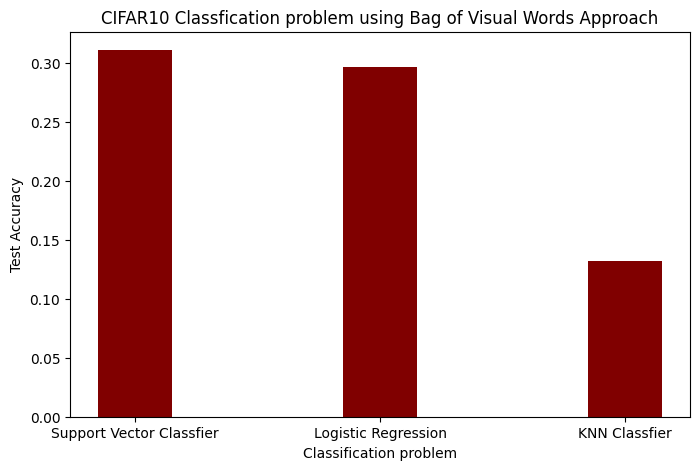

In [39]:
import numpy as np
import matplotlib.pyplot as plt


# creating the dataset
data = {'Support Vector Classfier':accuracy, 'Logistic Regression':CLR_accuracy, 'KNN Classfier':CKNN_accuracy}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon', width = 0.3)

plt.xlabel("Classification problem")
plt.ylabel("Test Accuracy")
plt.title("CIFAR10 Classfication problem using Bag of Visual Words Approach")
plt.show()